┌ Error: Multi-threaded parsing failed (are there newlines inside quoted fields?), falling back to single-threaded parsing
└ @ CSV ~/.julia/packages/CSV/OnldF/src/context.jl:652


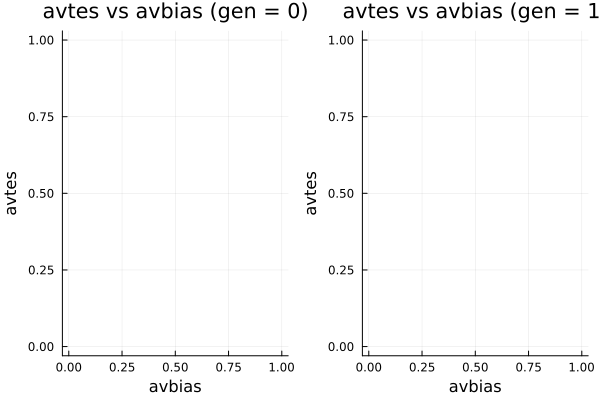

In [2]:
using CSV
using DataFrames
using Plots

# Define column names
column_names = ["rep", "gen", "popstat", "fwte", "avw", "min_w", "avtes", "avpopfreq",
                "fixed", "phase", "fwcli", "avcli", "fixcli",
                "avbias", "3tot", "3cluster", "sampleid"]

# Read the CSV file directly into a DataFrame
# Silently handle any inconsistencies in column numbers or types
df = CSV.File("test_file_7.1.out", 
              header=column_names, 
              delim='\t', 
              missingstring="missing",
              ignoreemptyrows=true, 
              silencewarnings=true, 
              comment="#") |> DataFrame

# Filter out lines starting with "Invade"
df = filter(row -> row[:rep] != "Invade", df)

# Handle inaccessible data in '3tot' and '3cluster' columns
# by splitting at comma, parsing the first part to Float64, and assigning missing to the second part if it doesn't exist
df[!, "3tot"] = [if ismissing(x) || isa(x, Int64)
                      missing
                  else
                      let parts = split(x, ',')
                          length(parts) > 1 ? parse(Float64, parts[1]) : missing
                      end
                  end for x in df[!, "3tot"]]

df[!, "3cluster"] = [if ismissing(x) || isa(x, Int64)
                          missing
                      else
                          let parts = split(x, ',')
                              length(parts) > 1 ? parse(Float64, parts[1]) : missing
                          end
                      end for x in df[!, "3cluster"]]

# Normalize avbias and avtes columns
df.avbias = (df.avbias .- minimum(df.avbias)) ./ (maximum(df.avbias) - minimum(df.avbias))
df.avtes = (df.avtes .- minimum(df.avtes)) ./ (maximum(df.avtes) - minimum(df.avtes))

# Filter the DataFrame by gen = 0 and gen = 1
df_gen_0 = filter(row -> ismissing(row[:gen]) ? false : row[:gen] == 0, df)
df_gen_1 = filter(row -> ismissing(row[:gen]) ? false : row[:gen] == 1, df)

# Create side-by-side plots for avbias vs avtes with gen = 0 and gen = 1
p1 = scatter(df_gen_0.avbias, df_gen_0.avtes, legend=false, xlabel="avbias", ylabel="avtes", title="avtes vs avbias (gen = 0)")
p2 = scatter(df_gen_1.avbias, df_gen_1.avtes, legend=false, xlabel="avbias", ylabel="avtes", title="avtes vs avbias (gen = 1)")

# Customize plot aesthetics
default(titlefontsize = 10, tickfontsize = 8, legendfontsize = 8)
plot(p1, p2, layout=(1, 2))
